# Simulations for determining general variance of noise across various imaging cases

In [9]:
from visibilities import *
from images import *
import matplotlib.pyplot as plt
import matplotlib
import numpy
import helpers
import os
import logging, sys
import math

cmap='turbo'
matplotlib.rcParams['figure.figsize'] = [10, 5]
plt.set_loglevel("critical")

## Load visibility layouts for long and short baseline databases, the same division is used for all three of our test cases so can use the same layout for all

In [10]:
from rascil.processing_components import create_visibility_from_ms

[vt] = create_visibility_from_ms('data/SGRA.ms')
[vs] = create_visibility_from_ms('data3/SGRA_small_baselines.ms')
[vl] = create_visibility_from_ms('data3/SGRA_long_baselines.ms')

create_visibility_from_ms: {'type': 'Measurement Set', 'subType': '', 'readme': 'This is a MeasurementSet Table holding measurements from a Telescope\n'}
create_visibility_from_ms: Reading unique fields [0], unique data descriptions [0]
create_visibility_from_ms: Found 249600 rows
create_visibility_from_ms: Found 1 channels
create_visibility_from_ms: Reading all 1 channels
create_visibility_from_ms: Observation from 2000-01-01 17:37:07.746 to 2000-01-01 21:35:07.746
create_visibility_from_ms: {'type': 'Measurement Set', 'subType': 'UVFITS', 'readme': 'This is a MeasurementSet Table holding measurements from a Telescope\nThis is a measurement set Table holding astronomical observations\n'}
create_visibility_from_ms: Reading unique fields [0], unique data descriptions [0]
create_visibility_from_ms: Found 183337 rows
create_visibility_from_ms: Found 1 channels
create_visibility_from_ms: Reading all 1 channels
create_visibility_from_ms: Observation from 2000-01-01 17:37:07.746 to 2000-01-0

/home/sunwang/.local/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


create_visibility_from_ms: {'type': 'Measurement Set', 'subType': 'UVFITS', 'readme': 'This is a MeasurementSet Table holding measurements from a Telescope\nThis is a measurement set Table holding astronomical observations\n'}
create_visibility_from_ms: Reading unique fields [0], unique data descriptions [0]
create_visibility_from_ms: Found 76909 rows
create_visibility_from_ms: Found 1 channels
create_visibility_from_ms: Reading all 1 channels
create_visibility_from_ms: Observation from 2000-01-01 17:37:07.746 to 2000-01-01 21:35:07.746


/home/sunwang/.local/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)
/home/sunwang/.local/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapp

## Simulations to determine why dirty images in RASCIL have higher signal strengths

### Just inverse FFT, no gridding, no weighting, norms are preserved when taking into account scaling

In [11]:
coeff_data = numpy.zeros((512, 512), dtype=numpy.csingle)
coeff_data[128:256, 142:259] = 1
coeff_data[200:213, 156:210] = 3

scaling_factor = math.sqrt(coeff_data.size)

image_data = scaling_factor * numpy.fft.ifft2(coeff_data)
transform_data = numpy.fft.fft2(image_data) / scaling_factor

print(str(numpy.linalg.norm(coeff_data)) + " " + str(numpy.linalg.norm(image_data)) + " " + \
      str(numpy.linalg.norm(transform_data)))

143.49913 143.4991289172166 143.49912891721678


### Simple natural weighting case, with gridding

advise_wide_field: (max_wavelength) Maximum wavelength 0.300 (meters)
advise_wide_field: (min_wavelength) Minimum wavelength 0.300 (meters)
advise_wide_field: (maximum_baseline) Maximum baseline 24331.5 (wavelengths)
advise_wide_field: (maximum_w) Maximum w 10597.6 (wavelengths)
advise_wide_field: (diameter) Station/dish diameter 13.5 (meters)
advise_wide_field: (primary_beam_fov) Primary beam 0.0222 (rad) 1.27 (deg) 4.58e+03 (asec)
advise_wide_field: (image_fov) Image field of view 0.0666 (rad) 3.82 (deg) 1.37e+04 (asec)
advise_wide_field: (synthesized_beam) Synthesized beam 4.11e-05 (rad) 0.00235 (deg) 8.48 (asec)
advise_wide_field: (cellsize) Cellsize 1.03e-05 (rad) 0.000589 (deg) 2.12 (asec)
advice_wide_field: (npixels) Npixels per side = 6484
advice_wide_field: (npixels2) Npixels (power of 2) per side = 8192
advice_wide_field: (npixels23) Npixels (power of 2, 3) per side = 8192
advice_wide_field: (npixels_min) Npixels (power of 2, 3, 4, 5) per side = 6561

advice_wide_field: (w_sa

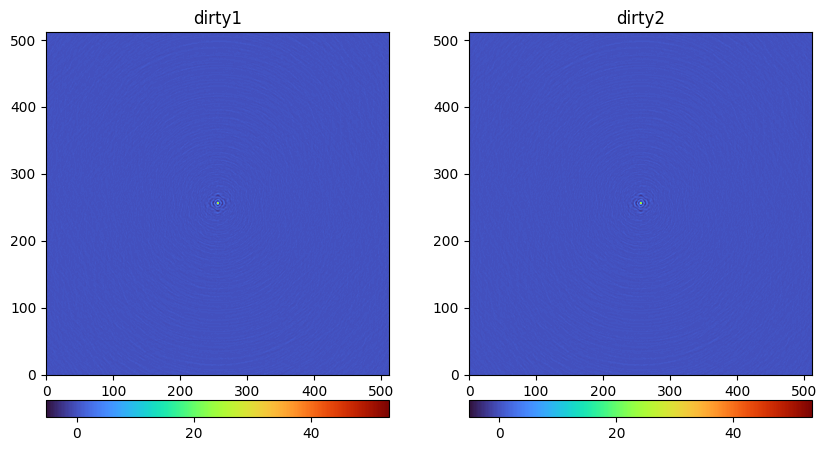

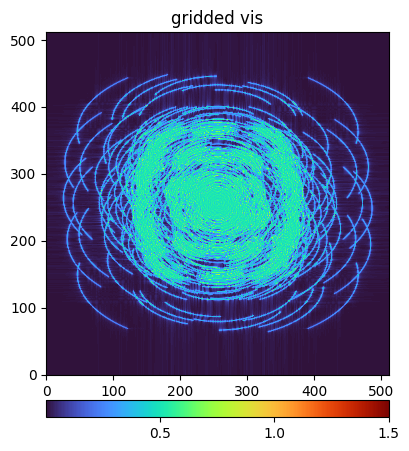

In [27]:
from ska_sdp_func_python.grid_data import grid_visibility_weight_to_griddata,griddata_visibility_reweight
from ska_sdp_func_python.imaging import invert_ng, predict_ng
from ska_sdp_func_python.imaging.base import shift_vis_to_image


simple_vis, cellsize, im = visibilities_from_image(vt,'data/SGRA_full_gt.fits',return_cellsize=True, \
                                                        return_image=True,scale_factor=1.8)
model = create_image_from_visibility(simple_vis,cellsize=cellsize,npixel=512)

simple_vis = shift_vis_to_image(simple_vis, model, tangent=True, inverse=False)

grid_weights = create_griddata_from_image(model,polarisation_frame=model.image_acc.polarisation_frame)
grid_weights = grid_visibility_weight_to_griddata(vt,grid_weights)
simple_vis = griddata_visibility_reweight(vt, grid_weights[0], weighting="uniform", robustness=0, sumwt=grid_weights[1])
#simple_vis["vis"].data[...] = 1 / math.sqrt(simple_vis["vis"].data.size)
print("Initial vis norm: " + str(numpy.linalg.norm(simple_vis["vis"].data)))

dirty, sumwt = invert_ng(simple_vis, model, context='ng', normalise=False)
print("Image norm: " + str(numpy.linalg.norm(dirty.pixels.data)))

gv = numpy.fft.fftshift(numpy.fft.fft2(numpy.fft.ifftshift(dirty.pixels.data))) / scaling_factor
print("vis norm (g1): " + str(numpy.linalg.norm(gv)))

dirty2, sumwt = invert_ng(simple_vis, model, context='ng', normalise=False)
print("Image norm 2: " + str(numpy.linalg.norm(dirty2.pixels.data)))

gv2 = numpy.fft.fftshift(numpy.fft.fft2(numpy.fft.ifftshift(dirty2.pixels.data))) / scaling_factor
print("vis norm (g2): " + str(numpy.linalg.norm(gv2)))

helpers.plotNImages([dirty.pixels.data, dirty2.pixels.data], ["dirty1", "dirty2"], cmap)

helpers.plotNImages([numpy.abs(gv)], ["gridded vis"], cmap)



## Compute Noise for Long and Short baselines for Sgr A

### Read visibilities into long and short visibilities respectively

Model image plate scale (arcsec) is 3.814768e+00
Model image plate scale (arcsec) is 3.814768e+00


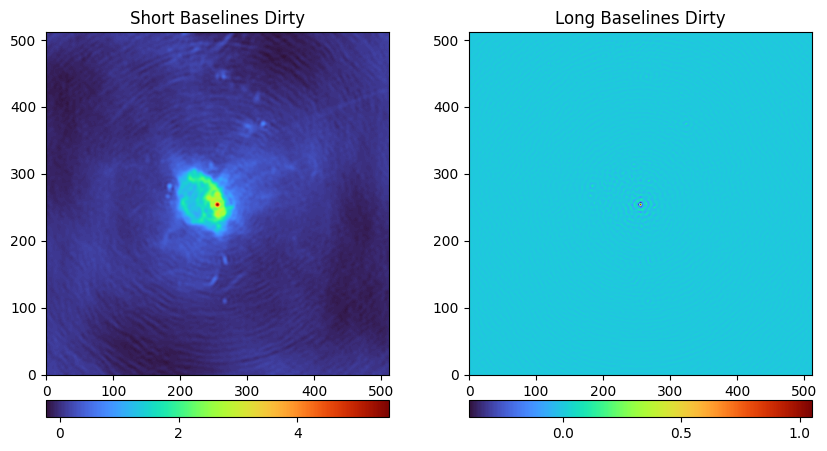

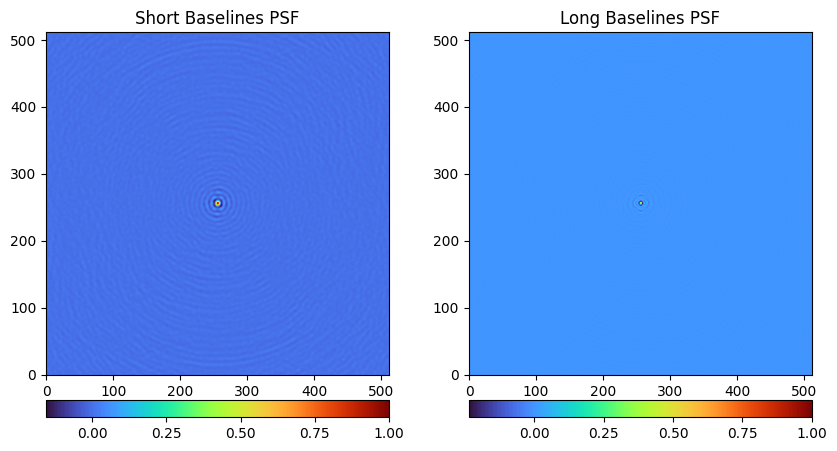

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 24331.536075 wavelengths
create_image_from_visibility: Critical cellsize = 0.000021 radians, 0.001177 degrees
create_image_from_visibility: Cellsize = 1.84945e-05 radians, 0.00105966 degrees
create_image_from_visibility: image shape is (1, 1, 512, 512)
Model image plate scale (arcsec) is 3.814768e+00


In [39]:
logging.getLogger().setLevel(logging.CRITICAL)

vt, full_cellsize, im = visibilities_from_image(vt,'data/SGRA_full_gt.fits',return_cellsize=True,return_image=True,scale_factor=1.8)
stdv_real = numpy.std(numpy.array(vt.vis.real).flatten())
stdv_imag = numpy.std(numpy.array(vt.vis.imag).flatten())
dev = numpy.std(vt.vis.data.flatten())

vl, cell_size, im = visibilities_from_image(vl,'data/SGRA_full_gt.fits',return_cellsize=True,return_image=True, \
                                            scale_factor=1.8, override_cellsize=True, ocellsize=full_cellsize)
vs, cell_size, im = visibilities_from_image(vs,'data/SGRA_full_gt.fits',return_cellsize=True,return_image=True, \
                                            scale_factor=1.8, override_cellsize=True, ocellsize=full_cellsize)

dirty_l, psf_l = dirty_psf_from_visibilities(vl, full_cellsize, npix=512, weighting="uniform")
dirty_s, psf_s = dirty_psf_from_visibilities(vs, full_cellsize, npix=512, weighting="uniform")

helpers.plotNImages([dirty_s.pixels.data, dirty_l.pixels.data], ["Short Baselines Dirty", "Long Baselines Dirty"], cmap)
helpers.plotNImages([psf_s.pixels.data, psf_l.pixels.data], ["Short Baselines PSF", "Long Baselines PSF"], cmap)

logging.getLogger().setLevel(logging.NOTSET)

vis1 = helpers.addNoiseToVis(vl, 2, real_deviation=stdv_real, imag_deviation=stdv_imag)
img1, psf1 = dirty_psf_from_visibilities(vis1,cell_size,npix=512)

### Compute long baselines variance in image plane for some given amount of noise

### Same as above but for short baseline visibilities

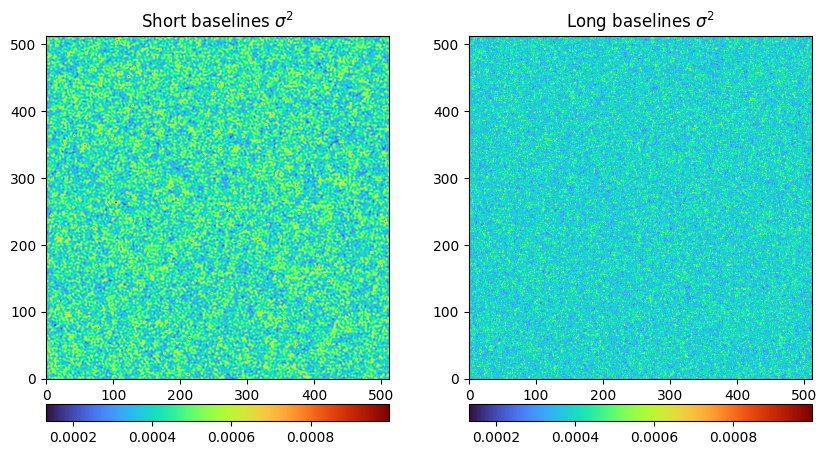

SGRA Mean variance for short baselines: 0.00043287428472851976
SGRA Mean variance for long baselines: 0.0003925801213612674


In [4]:
varimgs = helpers.readFits("results/noise_results/SGRA_short_variance_pixel.fits")
varimgl = helpers.readFits("results/noise_results/SGRA_long_variance_pixel.fits")

mean_var_s = numpy.mean(varimgs.flatten())
mean_var_l = numpy.mean(varimgl.flatten())

helpers.plotNImages([varimgs, varimgl], ["Short baselines $\sigma^2$", "Long baselines $\sigma^2$"], cmap, same_scale=True)
print("SGRA Mean variance for short baselines: " + str(mean_var_s))
print("SGRA Mean variance for long baselines: " + str(mean_var_l))

### Compute variance in the visibility domain

### Now compute variance on reconstructed short baselines

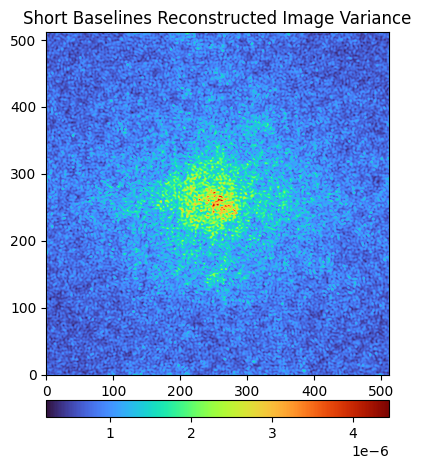

Mean reconstruction variance: 9.321283127809393e-07


In [5]:
varimg = helpers.readFits("results/noise_results/SGRA_reconstruction_variance_pixel.fits")
mean_var_r = numpy.mean(varimg.flatten())
helpers.plotNImages([varimg], ["Short Baselines Reconstructed Image Variance"], cmap)
print("Mean reconstruction variance: " + str(mean_var_r))

# Estimation of noise Sgr A

### For visibility noise, use a sliding window on the long baselines dirty and estimated the variance within

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 24331.536075 wavelengths
create_image_from_visibility: Critical cellsize = 0.000021 radians, 0.001177 degrees
create_image_from_visibility: Cellsize = 1.84945e-05 radians, 0.00105966 degrees
create_image_from_visibility: image shape is (1, 1, 512, 512)
Model image plate scale (arcsec) is 3.814768e+00
0.00044741584301457806
0.00046568155060012334


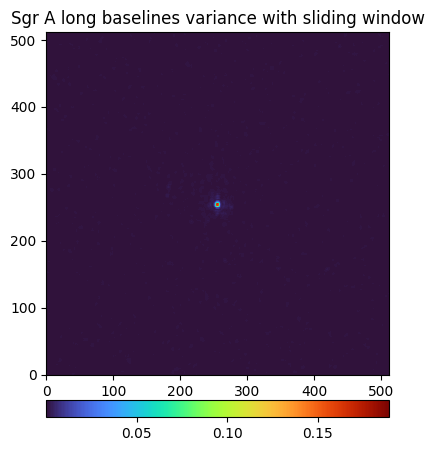

In [6]:
window_hsize = 2

est_vis = helpers.addNoiseToVis(vl, 2, real_deviation=stdv_real, imag_deviation=stdv_imag)
est_img, est_psf = dirty_psf_from_visibilities(est_vis,cell_size,npix=512)
est_img = est_img.pixels.data
while len(est_img.shape) > 2:
    est_img = est_img[0]

estimated_variance = numpy.zeros(est_img.shape)
    
#convolving initial signal with a variance estimation kernel with a size 2xwindow_hsize+1
for y in range(est_img.shape[1]):
    for x in range(est_img.shape[0]):
        start_x = max(x - window_hsize, 0)
        end_x = min(x + window_hsize + 1, est_img.shape[0])
        start_y = max(y - window_hsize, 0)
        end_y = min(y + window_hsize + 1, est_img.shape[1])
        
        estimated_variance[x, y] = numpy.var(est_img[start_x:end_x, start_y:end_y])

print(numpy.mean(estimated_variance))
print(numpy.var(est_img))
        
helpers.plotNImages([estimated_variance], ["Sgr A long baselines variance with sliding window"], cmap)

### For reconstruction noise

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 7499.408229 wavelengths
create_image_from_visibility: Critical cellsize = 0.000067 radians, 0.003820 degrees
create_image_from_visibility: Cellsize = 1.84945e-05 radians, 0.00105966 degrees
create_image_from_visibility: image shape is (1, 1, 512, 512)
Model image plate scale (arcsec) is 3.814768e+00


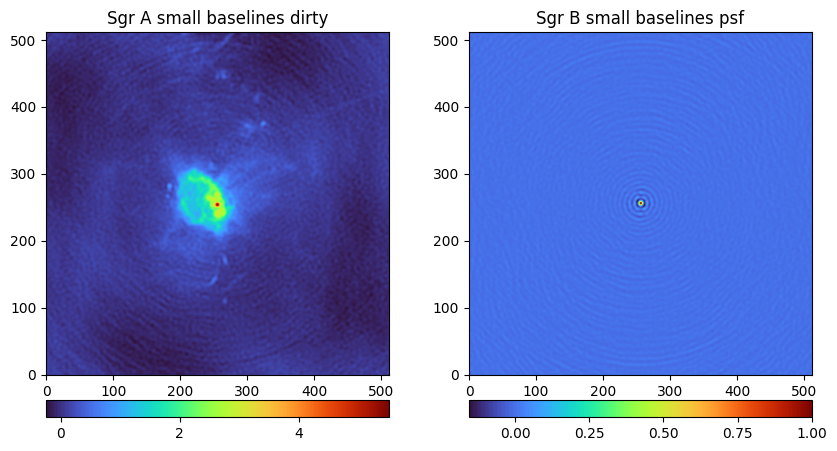

In [7]:
num_maj_cycles = 3

recon_image = numpy.zeros(512 * 512)

lambdas = [1, 2, 4]

tmp_output_name = "tmp_out.fits"
tmp_dirty_name = "tmp_dirty.fits"
tmp_psf_name = "tmp_psf.fits"

est_recon_vis = helpers.addNoiseToVis(vs, 2, real_deviation=stdv_real, imag_deviation=stdv_imag)
curr_dirty, curr_psf = dirty_psf_from_visibilities(est_recon_vis,cell_size,npix=512)
curr_dirty = curr_dirty.pixels.data
while len(curr_dirty.shape) > 2:
    curr_dirty = curr_dirty[0]
        
curr_psf = curr_psf.pixels.data
while len(curr_psf.shape) > 2:
    curr_psf = curr_psf[0]
        
helpers.plotNImages([curr_dirty, curr_psf], ["Sgr A small baselines dirty", "Sgr B small baselines psf"], cmap)

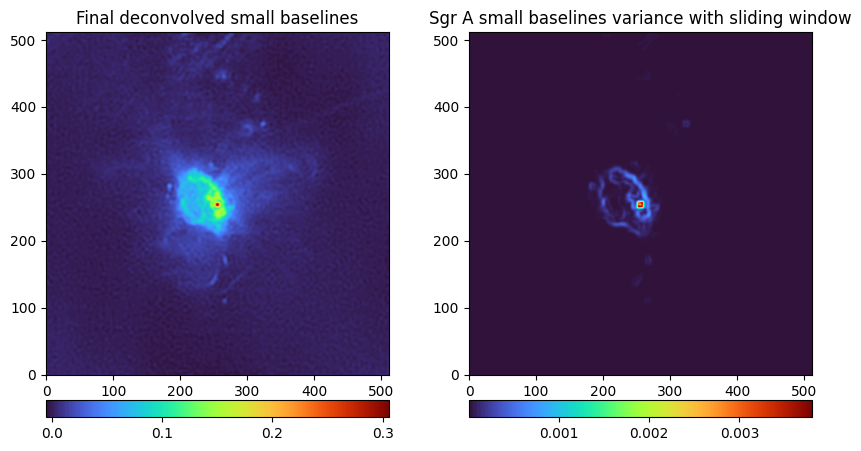

7.215684637804273e-06


In [8]:
final_deconvolved = helpers.readFits("results/noise_results/SGRA_short_finaldeconv.fits")
        
estimated_variance = numpy.zeros(est_img.shape)

window_hsize = 4

#convolving initial signal with a variance estimation kernel with a size 2xwindow_hsize+1
for y in range(final_deconvolved.shape[1]):
    for x in range(final_deconvolved.shape[0]):
        start_x = max(x - window_hsize, 0)
        end_x = min(x + window_hsize + 1, final_deconvolved.shape[0])
        start_y = max(y - window_hsize, 0)
        end_y = min(y + window_hsize + 1, final_deconvolved.shape[1])
        
        estimated_variance[x, y] = numpy.var(final_deconvolved[start_x:end_x, start_y:end_y])
        
helpers.plotNImages([final_deconvolved, estimated_variance], \
                    ["Final deconvolved small baselines", "Sgr A small baselines variance with sliding window"], cmap)

print(numpy.mean(estimated_variance))

### Experiments to see how much influence the reconstruction noise value has on reconstruction

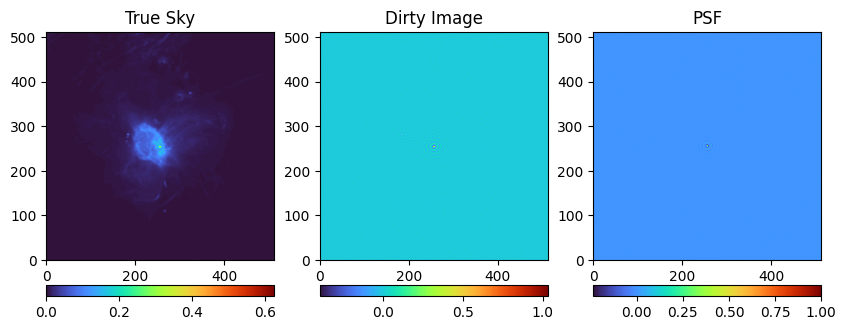

In [5]:
dirty = helpers.readFits("noise_tests/SGRA_long_dirty.fits")
psf = helpers.readFits("noise_tests/SGRA_long_psf.fits")
gt = helpers.readFits("noise_tests/SGRA_full_gt.fits")
lowres = helpers.readFits("noise_tests/SGRA_short_gt.fits")

helpers.plotGDP(gt, dirty, psf, cmap)

path = "results/noise_results/SGRA_eta/"

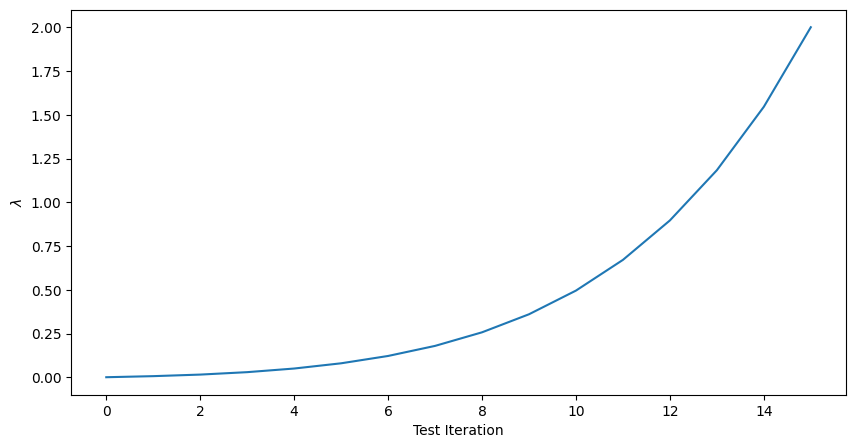

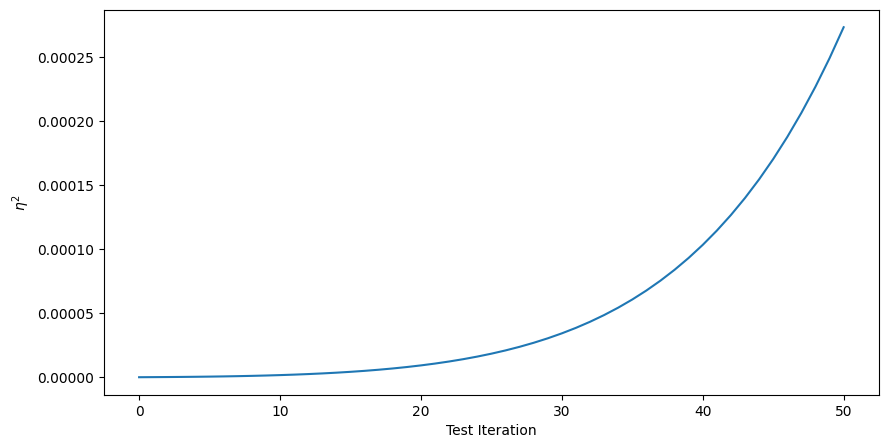

In [6]:
num_samples_lambda = 15

lambda_low = 0.001
lambda_high = 2

step = 1 / float(num_samples_lambda)

x_vals = numpy.arange(0, 1 + step, step)

lambdas = [0] * len(x_vals)
for i, v in enumerate(x_vals):
    lambdas[i] = helpers.exp_growth(v, lambda_low, lambda_high, steepness = 0.5)
    
helpers.plot1D(range(0, len(lambdas)), lambdas, "Test Iteration", "$\lambda$")

num_samples_eta = 50

estimated_sigma = numpy.var(dirty)

eta_low = estimated_sigma / 10000
eta_high = estimated_sigma

step_eta = 1 / float(num_samples_eta)
x_vals_eta = numpy.arange(0, 1 + step_eta, step_eta)

etas = [0] * len(x_vals_eta)
for i, v in enumerate(x_vals_eta):
    etas[i] = helpers.exp_growth(v, eta_low, eta_high, steepness = 0.5)
    
helpers.plot1D(range(0, len(etas)), etas, "Test Iteration", "$\eta^2$")

In [ ]:
for eta in etas:
    snrs = [0] * len(lambdas)
    rmses = [0] * len(lambdas)
    abserr = [0] * len(lambdas)
    errstd = [0] * len(lambdas)
    ssims = [0] * len(lambdas)

    tmp_dirty_fn = "tmp_dirty.fits"
    tmp_psf_fn = "tmp_psf.fits"
    tmp_low_fn = "tmp_low.fits"
    
    curr_path = path + "eta_" + str(eta) + "/"

    helpers.write_nparr_to_fits(dirty, tmp_dirty_fn)
    helpers.write_nparr_to_fits(psf, tmp_psf_fn)
    helpers.write_nparr_to_fits(lowres, tmp_low_fn)

    for i, curr_lambda in enumerate(lambdas):
        curr_output_name = curr_path + "lambda_" + str(curr_lambda) + ".fits"
        if not os.path.exists(curr_path):
            os.mkdir(curr_path)
        os.system("julia julia_rascil_scripts/make_multistep.jl " + str(curr_lambda) + " " + tmp_psf_fn + \
                  " " + tmp_dirty_fn + " " + tmp_low_fn + " " + str(eta) + " " + str(estimated_sigma) + " " + curr_output_name)
        recon = fits.open(curr_output_name)[0].data
        snrs[i] = helpers.compute_snr(gt, recon)
        rmses[i] = helpers.compute_rmse(gt, recon)
        abserr[i] = helpers.compute_maxabserr(gt, recon)
        errstd[i] = helpers.compute_errstd(gt, recon)
        ssims[i] = helpers.compute_ssim(gt, recon)

    helpers.write_to_csv(snrs, curr_path + "snr.dat")
    helpers.write_to_csv(rmses, curr_path + "rmse.dat")
    helpers.write_to_csv(abserr, curr_path + "abs_err.dat")
    helpers.write_to_csv(errstd, curr_path + "std.dat")
    helpers.write_to_csv(ssims, curr_path + "ssim.dat")

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

eta_snrs = numpy.zeros((len(x_vals_eta), len(lambdas)))

for i, eta in enumerate(x_vals_eta):
    filename = path + "eta_" + str(eta) + "/snr.dat"
    eta_snrs[i] = helpers.read_csv(filename)

fig, axes = plt.subplots(1, 1)

x_vals_eta /= estimated_sigma

im = axes.pcolormesh(lambdas, x_vals_eta, eta_snrs)

divider = make_axes_locatable(axes)
cax = divider.append_axes("right", size="5%", pad=0.25)

cb = fig.colorbar(im, orientation='vertical', cax=cax)
#cb.ax.locator_params(nbins=5)

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'results/noise_results/SGRA_eta/eta_0.0/snr.dat'

## Compute Noise for Long and Short baselines for Sgr B2

### Read visibilities into long and short visibilities respectively

Model image plate scale (arcsec) is 3.814768e+00
Model image plate scale (arcsec) is 3.814768e+00


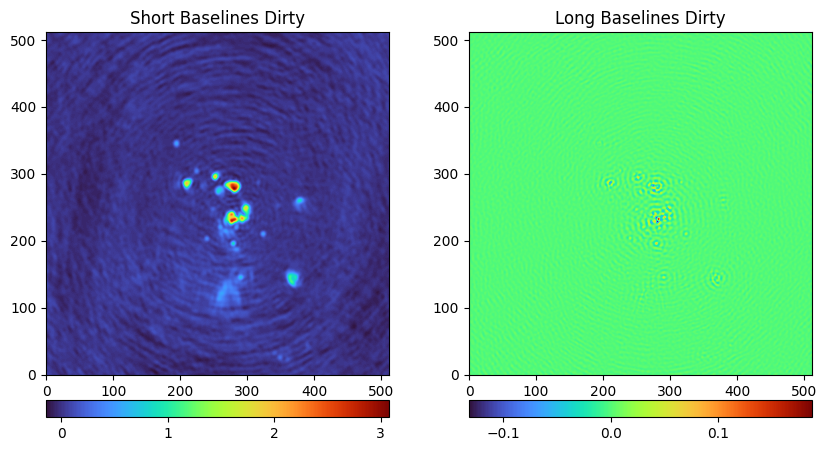

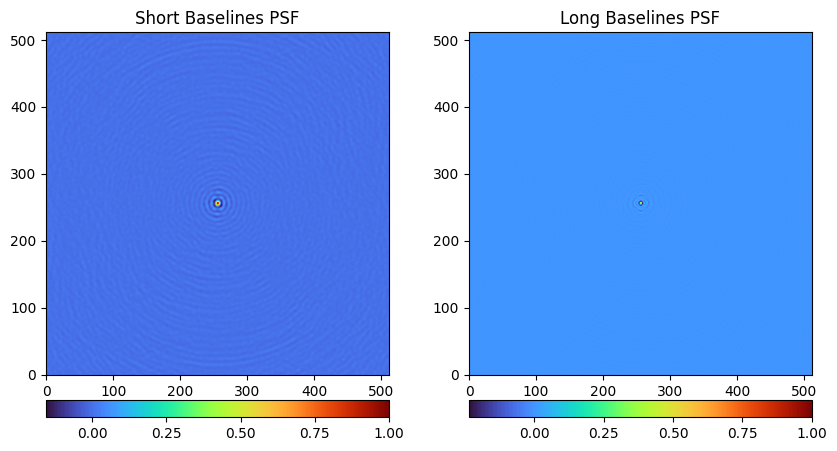

In [13]:
logging.getLogger().setLevel(logging.CRITICAL)

vt, full_cellsize, im = visibilities_from_image(vt,'data/SGRB_full_gt.fits',return_cellsize=True,return_image=True,scale_factor=1.8)
stdv_real = numpy.std(numpy.array(vt.vis.real).flatten())
stdv_imag = numpy.std(numpy.array(vt.vis.imag).flatten())
dev = numpy.std(vt.vis.data.flatten())

vl, cell_size, im = visibilities_from_image(vl,'data/SGRB_full_gt.fits',return_cellsize=True,return_image=True, \
                                            scale_factor=1.8, override_cellsize=True, ocellsize=full_cellsize)
vs, cell_size, im = visibilities_from_image(vs,'data/SGRB_full_gt.fits',return_cellsize=True,return_image=True, \
                                            scale_factor=1.8, override_cellsize=True, ocellsize=full_cellsize)

dirty_l, psf_l = dirty_psf_from_visibilities(vl, full_cellsize, npix=512, weighting="uniform")
dirty_s, psf_s = dirty_psf_from_visibilities(vs, full_cellsize, npix=512, weighting="uniform")

helpers.plotNImages([dirty_s.pixels.data, dirty_l.pixels.data], ["Short Baselines Dirty", "Long Baselines Dirty"], cmap)
helpers.plotNImages([psf_s.pixels.data, psf_l.pixels.data], ["Short Baselines PSF", "Long Baselines PSF"], cmap)

logging.getLogger().setLevel(logging.NOTSET)

### Compute long baselines variance in image plane for some given amount of noise

### Same as above but for short baseline visibilities

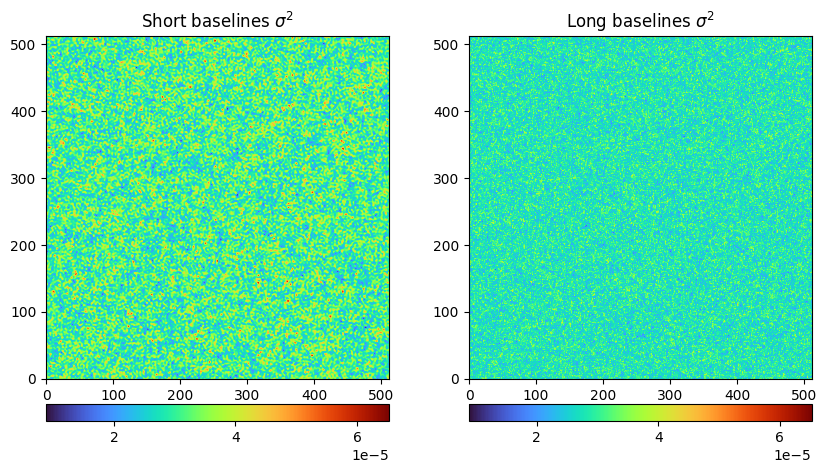

Mean variance for short baselines: 3.0866535133685566e-05
Mean variance for long baselines: 2.7938087049445942e-05


In [14]:
varimgs = helpers.readFits("results/noise_results/SGRB_short_variance_pixel.fits")
varimgl = helpers.readFits("results/noise_results/SGRB_long_variance_pixel.fits")

mean_var_s = numpy.mean(varimgs.flatten())
mean_var_l = numpy.mean(varimgl.flatten())

helpers.plotNImages([varimgs, varimgl], ["Short baselines $\sigma^2$", "Long baselines $\sigma^2$"], cmap, same_scale=True)
print("Mean variance for short baselines: " + str(mean_var_s))
print("Mean variance for long baselines: " + str(mean_var_l))

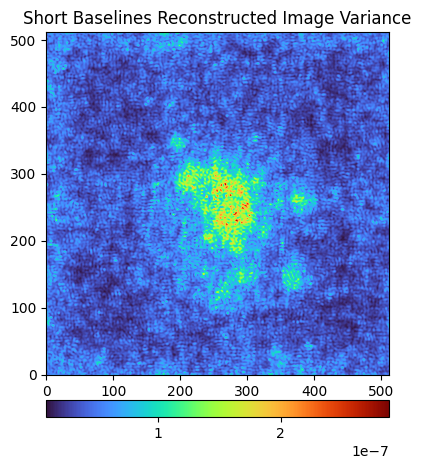

Mean reconstruction variance: 4.6528318379354664e-08


In [15]:
varimg = helpers.readFits("results/noise_results/SGRB_reconstruction_variance_pixel.fits")
mean_var_r = numpy.mean(varimg.flatten())
helpers.plotNImages([varimg], ["Short Baselines Reconstructed Image Variance"], cmap)
print("Mean reconstruction variance: " + str(mean_var_r))

# Estimation of noise for Sgr B2

### For visibility noise, use a sliding window on the long baselines dirty and estimated the variance within

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 24331.536075 wavelengths
create_image_from_visibility: Critical cellsize = 0.000021 radians, 0.001177 degrees
create_image_from_visibility: Cellsize = 1.84945e-05 radians, 0.00105966 degrees
create_image_from_visibility: image shape is (1, 1, 512, 512)
Model image plate scale (arcsec) is 3.814768e+00
4.372712006418139e-05


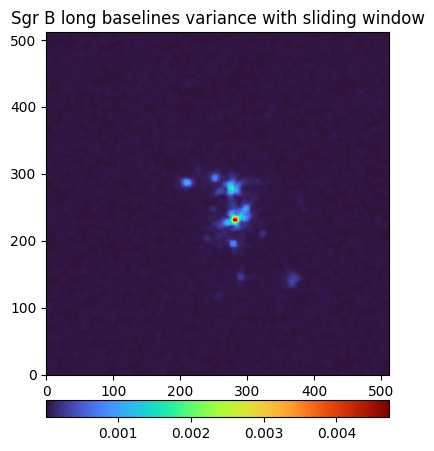

In [16]:
window_hsize = 4

est_vis = helpers.addNoiseToVis(vl, 2, real_deviation=stdv_real, imag_deviation=stdv_imag)
est_img, est_psf = dirty_psf_from_visibilities(est_vis,cell_size,npix=512)
est_img = est_img.pixels.data
while len(est_img.shape) > 2:
    est_img = est_img[0]

estimated_variance = numpy.zeros(est_img.shape)
    
#convolving initial signal with a variance estimation kernel with a size 2xwindow_hsize+1
for y in range(est_img.shape[1]):
    for x in range(est_img.shape[0]):
        start_x = max(x - window_hsize, 0)
        end_x = min(x + window_hsize + 1, est_img.shape[0])
        start_y = max(y - window_hsize, 0)
        end_y = min(y + window_hsize + 1, est_img.shape[1])
        
        estimated_variance[x, y] = numpy.var(est_img[start_x:end_x, start_y:end_y])

print(numpy.mean(estimated_variance))
        
helpers.plotNImages([estimated_variance], ["Sgr B long baselines variance with sliding window"], cmap)

### For reconstruction noise

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 7499.408229 wavelengths
create_image_from_visibility: Critical cellsize = 0.000067 radians, 0.003820 degrees
create_image_from_visibility: Cellsize = 1.84945e-05 radians, 0.00105966 degrees
create_image_from_visibility: image shape is (1, 1, 512, 512)
Model image plate scale (arcsec) is 3.814768e+00


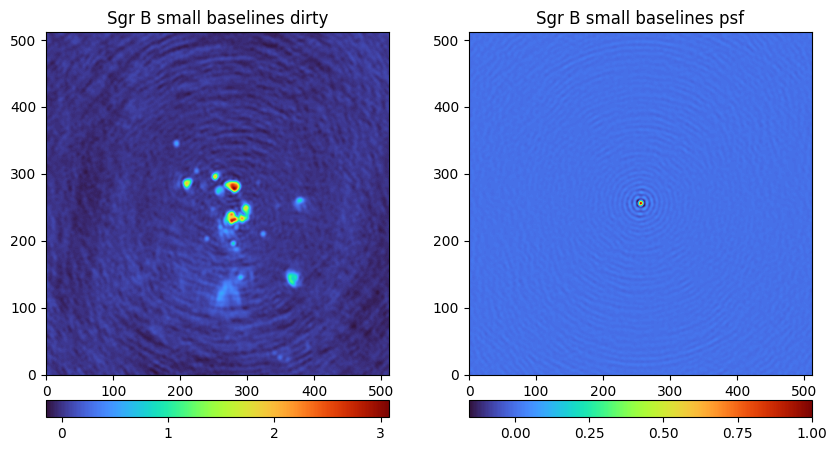

In [17]:
num_maj_cycles = 3

recon_image = numpy.zeros(512 * 512)

lambdas = [1, 2, 4]

tmp_output_name = "tmp_out.fits"
tmp_dirty_name = "tmp_dirty.fits"
tmp_psf_name = "tmp_psf.fits"

est_recon_vis = helpers.addNoiseToVis(vs, 2, real_deviation=stdv_real, imag_deviation=stdv_imag)
curr_dirty, curr_psf = dirty_psf_from_visibilities(est_recon_vis,cell_size,npix=512)
curr_dirty = curr_dirty.pixels.data
while len(curr_dirty.shape) > 2:
    curr_dirty = curr_dirty[0]
        
curr_psf = curr_psf.pixels.data
while len(curr_psf.shape) > 2:
    curr_psf = curr_psf[0]
        
helpers.plotNImages([curr_dirty, curr_psf], ["Sgr B small baselines dirty", "Sgr B small baselines psf"], cmap)

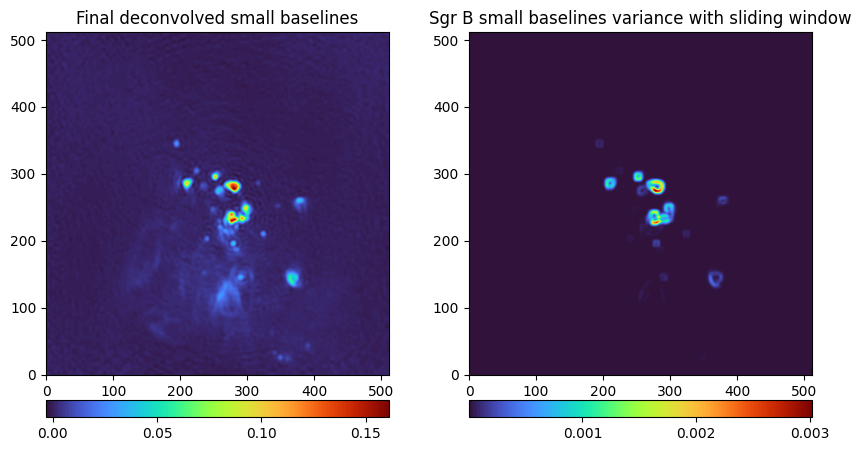

7.992930707363885e-06


In [18]:
final_deconvolved = helpers.readFits("results/noise_results/SGRB_short_finaldeconv.fits")
        
estimated_variance = numpy.zeros(est_img.shape)

window_hsize = 4

#convolving initial signal with a variance estimation kernel with a size 2xwindow_hsize+1
for y in range(final_deconvolved.shape[1]):
    for x in range(final_deconvolved.shape[0]):
        start_x = max(x - window_hsize, 0)
        end_x = min(x + window_hsize + 1, final_deconvolved.shape[0])
        start_y = max(y - window_hsize, 0)
        end_y = min(y + window_hsize + 1, final_deconvolved.shape[1])
        
        estimated_variance[x, y] = numpy.var(final_deconvolved[start_x:end_x, start_y:end_y])
        
helpers.plotNImages([final_deconvolved, estimated_variance], \
                    ["Final deconvolved small baselines", "Sgr B small baselines variance with sliding window"], cmap)

print(numpy.mean(estimated_variance))

## Compute Noise for Long and Short baselines for Sgr C

### Read visibilities into long and short visibilities respectively

Model image plate scale (arcsec) is 3.814768e+00
Model image plate scale (arcsec) is 3.814768e+00


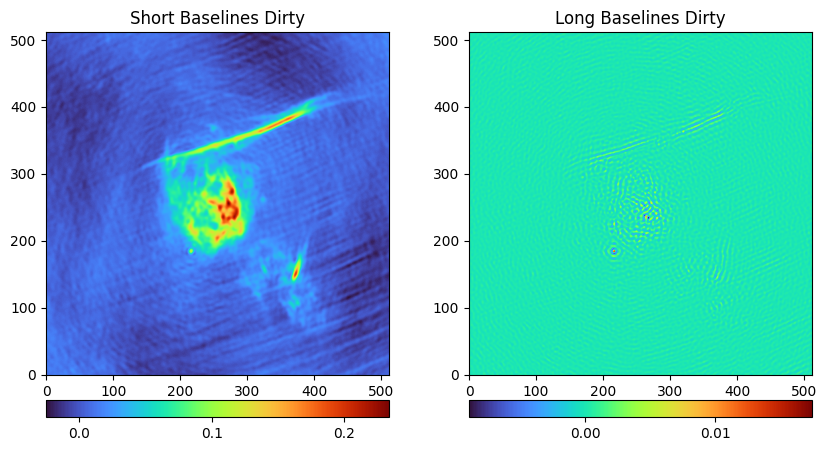

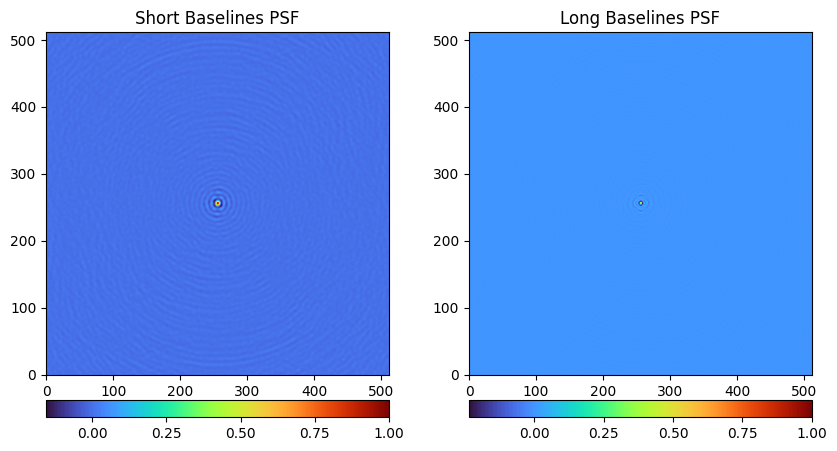

In [19]:
logging.getLogger().setLevel(logging.CRITICAL)

vt, full_cellsize, im = visibilities_from_image(vt,'data/SGRC_full_gt.fits',return_cellsize=True,return_image=True,scale_factor=1.8)
stdv_real = numpy.std(numpy.array(vt.vis.real).flatten())
stdv_imag = numpy.std(numpy.array(vt.vis.imag).flatten())
dev = numpy.std(vt.vis.data.flatten())

vl, cell_size, im = visibilities_from_image(vl,'data/SGRC_full_gt.fits',return_cellsize=True,return_image=True, \
                                            scale_factor=1.8, override_cellsize=True, ocellsize=full_cellsize)
vs, cell_size, im = visibilities_from_image(vs,'data/SGRC_full_gt.fits',return_cellsize=True,return_image=True, \
                                            scale_factor=1.8, override_cellsize=True, ocellsize=full_cellsize)

dirty_l, psf_l = dirty_psf_from_visibilities(vl, full_cellsize, npix=512, weighting="uniform")
dirty_s, psf_s = dirty_psf_from_visibilities(vs, full_cellsize, npix=512, weighting="uniform")

helpers.plotNImages([dirty_s.pixels.data, dirty_l.pixels.data], ["Short Baselines Dirty", "Long Baselines Dirty"], cmap)
helpers.plotNImages([psf_s.pixels.data, psf_l.pixels.data], ["Short Baselines PSF", "Long Baselines PSF"], cmap)

logging.getLogger().setLevel(logging.NOTSET)

### Compute long baselines variance in image plane for some given amount of noise

### Same as above but for short baseline visibilities

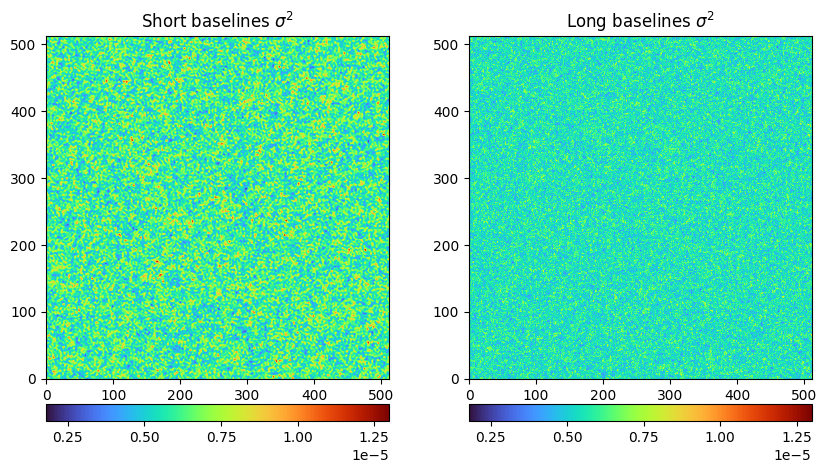

Mean variance for short baselines: 6.093636686701844e-06
Mean variance for long baselines: 5.523122647585829e-06


In [20]:
varimgs = helpers.readFits("results/noise_results/SGRC_short_variance_pixel.fits")
varimgl = helpers.readFits("results/noise_results/SGRC_long_variance_pixel.fits")

mean_var_s = numpy.mean(varimgs.flatten())
mean_var_l = numpy.mean(varimgl.flatten())

helpers.plotNImages([varimgs, varimgl], ["Short baselines $\sigma^2$", "Long baselines $\sigma^2$"], cmap, same_scale=True)
print("Mean variance for short baselines: " + str(mean_var_s))
print("Mean variance for long baselines: " + str(mean_var_l))

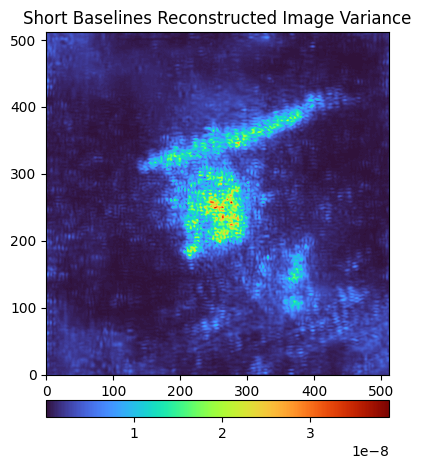

Mean reconstruction variance: 2.2933512206410987e-09


In [21]:
varimg = helpers.readFits("results/noise_results/SGRC_reconstruction_variance_pixel.fits")
mean_var_r = numpy.mean(varimg.flatten())
helpers.plotNImages([varimg], ["Short Baselines Reconstructed Image Variance"], cmap)
#helpers.plotNImages([varimg], [""], cmap, output_file="results/noise_results/SGRC_recon_noise.png")
print("Mean reconstruction variance: " + str(mean_var_r))

# Estimation of noise for Sgr C

### For visibility noise, use a sliding window on the long baselines dirty and estimated the variance within

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 24331.536075 wavelengths
create_image_from_visibility: Critical cellsize = 0.000021 radians, 0.001177 degrees
create_image_from_visibility: Cellsize = 1.84945e-05 radians, 0.00105966 degrees
create_image_from_visibility: image shape is (1, 1, 512, 512)
Model image plate scale (arcsec) is 3.814768e+00
5.906402585677585e-06


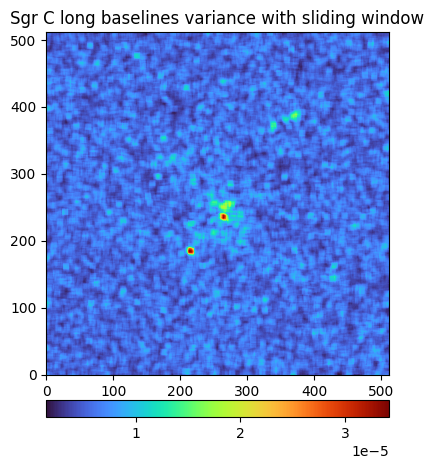

In [22]:
window_hsize = 4

est_vis = helpers.addNoiseToVis(vl, 2, real_deviation=stdv_real, imag_deviation=stdv_imag)
est_img, est_psf = dirty_psf_from_visibilities(est_vis,cell_size,npix=512)
est_img = est_img.pixels.data
while len(est_img.shape) > 2:
    est_img = est_img[0]

estimated_variance = numpy.zeros(est_img.shape)
    
#convolving initial signal with a variance estimation kernel with a size 2xwindow_hsize+1
for y in range(est_img.shape[1]):
    for x in range(est_img.shape[0]):
        start_x = max(x - window_hsize, 0)
        end_x = min(x + window_hsize + 1, est_img.shape[0])
        start_y = max(y - window_hsize, 0)
        end_y = min(y + window_hsize + 1, est_img.shape[1])
        
        estimated_variance[x, y] = numpy.var(est_img[start_x:end_x, start_y:end_y])

print(numpy.mean(estimated_variance))
        
helpers.plotNImages([estimated_variance], ["Sgr C long baselines variance with sliding window"], cmap)

### For reconstruction noise

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 7499.408229 wavelengths
create_image_from_visibility: Critical cellsize = 0.000067 radians, 0.003820 degrees
create_image_from_visibility: Cellsize = 1.84945e-05 radians, 0.00105966 degrees
create_image_from_visibility: image shape is (1, 1, 512, 512)
Model image plate scale (arcsec) is 3.814768e+00


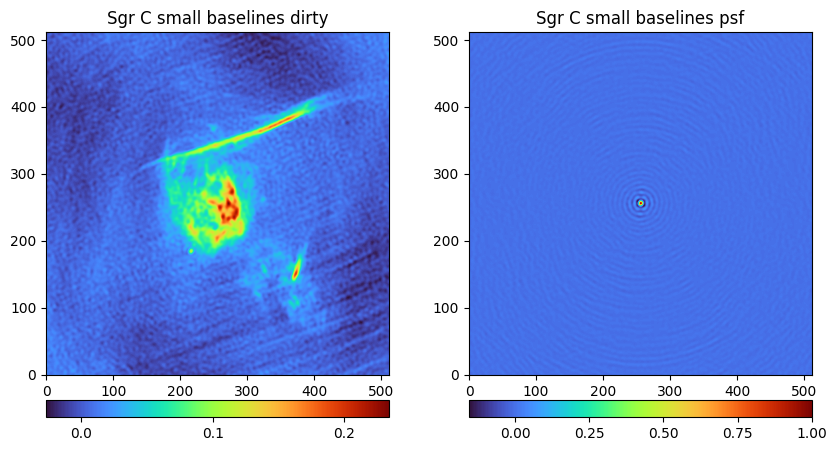

In [23]:
num_maj_cycles = 3

recon_image = numpy.zeros(512 * 512)

lambdas = [0.5, 0.5, 0.5]

tmp_output_name = "tmp_out.fits"
tmp_dirty_name = "tmp_dirty.fits"
tmp_psf_name = "tmp_psf.fits"

est_recon_vis = helpers.addNoiseToVis(vs, 2, real_deviation=stdv_real, imag_deviation=stdv_imag)
curr_dirty, curr_psf = dirty_psf_from_visibilities(est_recon_vis,cell_size,npix=512)
curr_dirty = curr_dirty.pixels.data
while len(curr_dirty.shape) > 2:
    curr_dirty = curr_dirty[0]
        
curr_psf = curr_psf.pixels.data
while len(curr_psf.shape) > 2:
    curr_psf = curr_psf[0]
        
helpers.plotNImages([curr_dirty, curr_psf], ["Sgr C small baselines dirty", "Sgr C small baselines psf"], cmap)

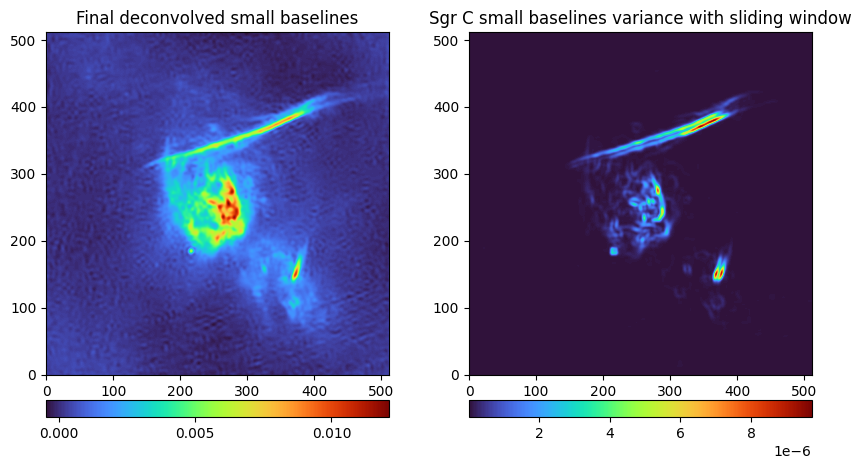

8.391732985980544e-08


In [24]:
final_deconvolved = helpers.readFits("results/noise_results/SGRC_short_finaldeconv.fits")
        
estimated_variance = numpy.zeros(est_img.shape)

window_hsize = 4

#convolving initial signal with a variance estimation kernel with a size 2xwindow_hsize+1
for y in range(final_deconvolved.shape[1]):
    for x in range(final_deconvolved.shape[0]):
        start_x = max(x - window_hsize, 0)
        end_x = min(x + window_hsize + 1, final_deconvolved.shape[0])
        start_y = max(y - window_hsize, 0)
        end_y = min(y + window_hsize + 1, final_deconvolved.shape[1])
        
        estimated_variance[x, y] = numpy.var(final_deconvolved[start_x:end_x, start_y:end_y])
        
helpers.plotNImages([final_deconvolved, estimated_variance], \
                    ["Final deconvolved small baselines", "Sgr C small baselines variance with sliding window"], cmap)

print(numpy.mean(estimated_variance))

## 